# Image Classification using NN

For tutorial on pytorch you can find many tutorials online 
for starters you can do the 60-minute tutorial by pytorch team at https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html



In [24]:
%matplotlib inline
import torch as T
import numpy as np
import os
from math import sqrt

os.environ['KMP_DUPLICATE_LIB_OK']='True'
T.set_default_dtype(T.float)
T.manual_seed(0)
np.random.seed(0)

# Set device to use
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
print(device)

cuda:0


# Buidling the network (MLP)
## Single MLP Layer
We define a class for a single MLP layer. The input size of this layer is $d_1$ and the output size is $d_2$
 

*   $A$ is a matrix of size $d_1 \times d_2$ 
*   $b$ is a row vector of size $d_2$
*   input to the layer is a row vector $x$ of size $x$
*   $\phi$ activation function 
Therefore the output of the layer will be
$$
  \phi(xA+b)
$$
which is a row vector of size $d_2$

In [25]:
class MLP_Layer:
    def __init__(self, d1, d2, activation=None ,req_grad=True, device=None):
        self.params = []
        self.activation = activation

        #Defining the learnable parameters and initializing them
        self.A = T.empty(d1, d2, requires_grad=req_grad, device=device)
        T.nn.init.normal_(self.A, mean=0., std=1. / sqrt(d1))
        self.b = T.empty(d2, requires_grad=req_grad, device=device)
        T.nn.init.normal_(self.b, mean=0., std=0.1 / sqrt(d1))

        self.params.append(self.A)
        self.params.append(self.b)

    # computer output of the layer given input
    def forward(self,x):
        x = x @ self.A  + self.b
        if self.activation is not None:
            x = self.activation(x)
        return x

## MLP net
Using the layer that we defined just now, we define a class for our MLP net. This class initializes an MLP network. it gets as input the size of input, size of output, and a **list of size** for hidden layers.



In [26]:
class MLP:
    def __init__(self, in_dim, out_dim, list_layers_sz, device=None):
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.layers = []
        self.params = []

        layers_sz = [in_dim]+list_layers_sz+[out_dim]

        for i in range(len(layers_sz)):
            if i == 0: continue
            
            activation = T.tanh
            # we don't use activation function for last layer
            if i == len(layers_sz)-1:
                activation = None
            
            new_layer = MLP_Layer(layers_sz[i-1],layers_sz[i],activation=activation,req_grad=True,device=device)
            
            self.layers.append(new_layer)
            self.params.extend(new_layer.params)
            
    #computes output of the network given input
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x


# Loss function 
We are planning to do binary classification over images therefore we use the logistic loss defined as
$$
  loss(y,\hat{y})=\frac{1}{S}\sum_{i=1}^{S} \log(1+e^{-y_i\hat{y}_i})
$$

In [27]:
def logistic_loss(y,y_hat):
    y=y.reshape((-1,1))
    return T.mean(T.log1p(T.exp(-y*y_hat)))

## SGD update
We write a function that updates the learnable parameters using SGD

In [28]:
def SGD_update(parameters, learning_rate):
    with T.no_grad():
        for param in parameters:
            param -= learning_rate * param.grad
            param.grad.zero_() # Otherwise Torch will keep accumulating gradients

### Train
This function trains the network given $n$ samples in matrix $X$ and labels $y$. 


*   X has size $n \times d$
*   y has size $n$



In [15]:
def train(net, X, y):
    epochs = 20
    batch_size = 32
    learning_rate = 1e-4
    n, d = X.size()
    losses = []
    for ep in range(epochs):
        if ep % 2 == 0:
            print("we are in epoch = %d" % ep)
        # Shuffling rows at the beginning of each epoch
        idx = np.arange(n)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]
        # for all batches: we compute the loss and update the parameters
        for batch_index in range(int(n/batch_size)):
            X_batch = X[batch_index*batch_size:(batch_index+1)*batch_size]
            y_batch = y[batch_index*batch_size:(batch_index+1)*batch_size]
            y_hat = net.forward(X_batch)
            loss = logistic_loss(y_batch, y_hat)
            loss.backward()
            SGD_update(net.params, learning_rate=learning_rate)
        # Computing train error at the end of epoch
        with T.no_grad():
            y_hat = net.forward(X)
            loss = logistic_loss(y,y_hat)
            losses.append(loss.item())
    return losses

In [16]:
def myplot(r, logscale=False):
    import matplotlib.pyplot as plt
    plt.close(), plt.ion(), plt.grid()
    _ = plt.xlabel('Epoch', fontsize=12)
    _ = plt.ylabel('Loss', fontsize=12)
    plt.plot(r, linewidth=2, linestyle='-', marker='o')
    if logscale: plt.xscale('log', basex=10.)
    plt.show(block=False)

# 0-1 loss of our net for data X with label y
def error_01(net, X, y):
    with T.no_grad():
        y_hat = net.forward(T.tensor(X, dtype=T.float,device=dev))
        a = np.sign(y_hat.cpu().numpy())
        err = 0
        for i in range(len(a)):
            if np.isclose(a[i], y[i]):
                continue
            err += 1

    return err/len(y)

## Making the data set

we are using CIFAR10 dataset that you can find the details here https://www.cs.toronto.edu/~kriz/cifar.html

We are going to make a binary classification taks by only picking the class #4(deer) and class #8(sheep).



*   $X$ i.e. data: is a numpy array of size $n \times 3 \times 32 \times 32$. we have $n$ images each is given in RGB format and has $32 \times 32$ pixels
*   $y$ i.e. labels: is a numpy array of $n$

in the following function, we pick the data corresponding to label #4 and #8. Flatten the data $(n,3,32,32)$ to $(n,3\times32\times 32)$ and return the result.



In [17]:
def create_binary_classification(X,y):
    import matplotlib.pyplot as plt
    # We are only interested in two classed out of 10 labels
    class1_label = 4
    class2_label = 8

    # flattening RGB for each sample (n,3,32,32) to (n,3*32*32)
    X = np.reshape(X,(len(X),-1))
    y = np.reshape(y,(len(y),-1))

    X_new = []
    y_new = []

    for i in range(np.size(y)):
        if y[i] == class1_label:
            y_new.append(+1.0)
            X_new.append(X[i])
        elif y[i]== class2_label:
            y_new.append(-1.0)
            X_new.append(X[i])

    X_new = np.array(X_new,dtype=np.float)
    y_new = np.array(y_new,dtype=np.float)

    return X_new,y_new


## Loading the dataset CIFAR10

In [18]:
from keras.datasets import cifar10
from matplotlib import pyplot as plt
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, y_train = create_binary_classification(x_train, y_train)
x_test, y_test = create_binary_classification(x_test, y_test)


we are in epoch = 0
we are in epoch = 2
we are in epoch = 4
we are in epoch = 6
we are in epoch = 8
we are in epoch = 10
we are in epoch = 12
we are in epoch = 14
we are in epoch = 16
we are in epoch = 18
Accuracy of our predictor on test data85.85 percent


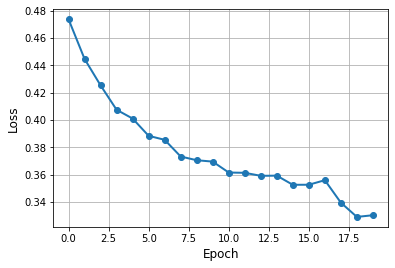

In [19]:
net = MLP(np.shape(x_train)[1], 1, [128, 32], device=dev)
losses = train(net, T.tensor(x_train, dtype=T.float,device=dev), T.tensor(y_train, dtype=T.float,device=dev))

err = error_01(net,x_test,y_test)
print("Accuracy of our predictor on test data"+str(100-100*err)+" percent")

myplot(losses, logscale=False)